In [1]:
from __future__ import division, print_function

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
import celerite
from celerite import terms

import pandas as pd

from astropy.stats import median_absolute_deviation as MAD

In [28]:
fn = '../data/206208968P-ep20160806.csv'
df = pd.read_csv(fn, skiprows=39)
df.time = df.t - df.t[0]
df.flux = df.fdt_t_roll_2D/ np.median(df.fdt_t_roll_2D) - 1.0
df.ferr = np.ones_like(df.flux) * MAD(df.flux)

(0, 5)

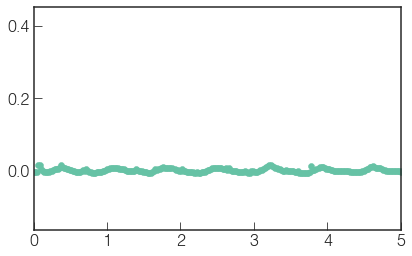

In [29]:
plt.scatter(df.time,df.flux)
plt.xlim(0,5)

In [30]:
y = df.flux[df.flux < 10]
t = df.time[df.flux < 10]
yerr = df.ferr[df.flux < 10]

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [31]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 1553.25432218


In [32]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -9.6355487168673655), ('kernel:terms[0]:log_omega0', 1.0986122886681098), ('kernel:terms[1]:log_S0', -9.9821223071473373), ('kernel:terms[1]:log_Q', 0.0), ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

parameter_names:
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')

parameter_vector:
[-9.63554872  1.09861229 -9.98212231  0.          1.09861229]

parameter_bounds:
['log_S0', 'log_omega0', 'log_S0', 'log_Q', 'log_omega0']



In [33]:
print(gp.get_parameter_names())
gp.freeze_parameter("kernel:terms[0]:log_omega0")
print(gp.get_parameter_names())
gp.thaw_parameter("kernel:terms[0]:log_omega0")
print(gp.get_parameter_names())

('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')
('kernel:terms[0]:log_S0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')


In [34]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

ValueError: too many values to unpack